In [15]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt

In [17]:
path1 = '/mnt/storage/datmh/SR_Data/TileDataSR/ID131_24.tif'
path2 = '/mnt/storage/datmh/SR_Data/TileDataSR/ID168_24.tif'

In [9]:
with rasterio.open(path1) as src: 
    r = src.read(1)
    g = src.read(2)
    b = src.read(3)
    
    meta = src.meta
    print(meta)
img_1 = np.stack((r,g,b), axis=-1)

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 6276, 'height': 6587, 'count': 3, 'crs': CRS.from_epsg(3857), 'transform': Affine(1.25, 0.0, 11816273.75,
       0.0, -1.25, 2377383.75)}


In [10]:
with rasterio.open(path2) as src: 
    r1 = src.read(1)
    g1 = src.read(2)
    b1 = src.read(3)
    
    meta = src.meta
    print(meta)
img_2 = np.stack((r1,g1,b1), axis=-1)

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 6276, 'height': 6587, 'count': 3, 'crs': CRS.from_epsg(3857), 'transform': Affine(1.25, 0.0, 11816273.75,
       0.0, -1.25, 2377383.75)}


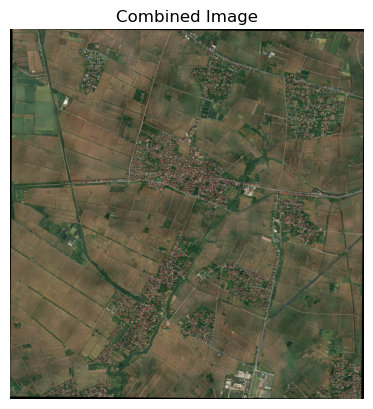

In [18]:
# Đường dẫn đến 2 file TIFF
file1_path = path1
file2_path = path2

# Đọc hai ảnh TIFF
with rasterio.open(file1_path) as src1, rasterio.open(file2_path) as src2:
    # Đọc dữ liệu từ cả hai ảnh
    img1 = src1.read()  # Shape: (channels, height, width)
    img2 = src2.read()  # Shape: (channels, height, width)

    # Lấy thông tin metadata từ ảnh đầu tiên để lưu lại sau này (nếu cần)
    meta = src1.meta

# Đảm bảo cả hai ảnh có cùng kích thước
if img1.shape != img2.shape:
    raise ValueError("Hai ảnh không có cùng kích thước hoặc số kênh.")

# Thực hiện ghép ảnh
# Điều kiện: nếu giá trị từ ảnh "last" (img2) khác 0, thì giữ giá trị của ảnh "last".
# Ngược lại, giữ giá trị của ảnh "first" (img1).
combined = np.where(img2 != 0, img2, img1)

# Hiển thị ảnh kết quả
plt.imshow(np.moveaxis(combined, 0, -1))  # Chuyển kênh về trục cuối (height, width, channels)
plt.axis('off')
plt.title("Combined Image")
plt.show()

In [ ]:
output_path = "/mnt/storage/datmh/SR_Data/GT_label/ID111_29_GT/ID111_29_GT.shp"
with rasterio.open(output_path, "w", **meta) as dst:
    dst.write(combined)

In [50]:
import geopandas as gpd
from shapely.geometry import Polygon, LineString
import rasterio
from rasterio.features import rasterize
import numpy as np
from rasterio.transform import from_origin

file = "/mnt/storage/datmh/SR_Data/GT_label/ID273_49_GT/ID273_49_GT.shp"
# Bước 1: Đọc file shapefile (Polygon)
polygon_gdf = gpd.read_file(file)

# Chuyển Polygon sang Polyline
def polygon_to_polyline(geometry):
    if isinstance(geometry, Polygon):
        return LineString(geometry.exterior.coords)  # Lấy đường viền ngoài
    return geometry

polyline_gdf = polygon_gdf.copy()
polyline_gdf['geometry'] = polyline_gdf['geometry'].apply(polygon_to_polyline)

# Bước 2: Rasterize Polyline thành binary array
# Định nghĩa kích thước raster và transform
width, height = 4161, 4226  # Kích thước ảnh đầu ra
x_min, y_min, x_max, y_max = polyline_gdf.total_bounds
transform = from_origin(x_min, y_max, (x_max - x_min) / width, (y_max - y_min) / height)

# Chuyển đổi polyline thành binary raster
shapes = ((geom, 1) for geom in polyline_gdf.geometry)
binary_array = rasterize(shapes, out_shape=(height, width), transform=transform, fill=0, dtype='uint8')

# Bước 3: Lưu binary array thành file TIFF
metadata = {
    'driver': 'GTiff',
    'dtype': 'uint8',
    'width': binary_array.shape[1],
    'height': binary_array.shape[0],
    'count': 1,
    'crs': polyline_gdf.crs,  # Hệ tọa độ từ shapefile
    'transform': transform,
}

save_path = f'/mnt/storage/datmh/SR_Data/GT_label/ID273_49_GT/ID273_49_GT.tif'
with rasterio.open(save_path, "w", **metadata) as dst:
    dst.write(binary_array, 1)

print("Tệp TIFF nhị phân đã được lưu thành công!")

Tệp TIFF nhị phân đã được lưu thành công!


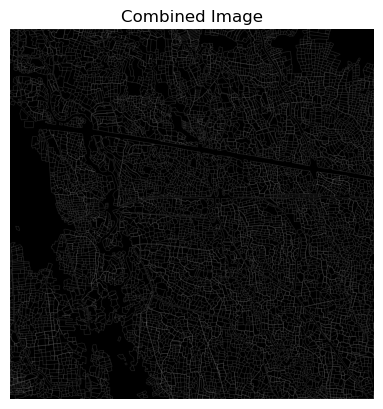

In [51]:
plt.imshow(binary_array, cmap='gray')  # Chuyển kênh về trục cuối (height, width, channels)
plt.axis('off')
plt.title("Combined Image")
plt.show()

In [ ]:
import rasterio
from rasterio.features import rasterize
import geopandas as gpd

# Đường dẫn tệp shapefile
shapefile_path = "/mnt/storage/datmh/SR_Data/GT_label/ID131_168_merge_1_GT/ID168_1_GT.shp"

# Đường dẫn tệp GeoTIFF đầu ra
output_tif_path = "/mnt/storage/datmh/SR_Data/GT_label/ID131_168_merge_1_GT/ID168_1_GT.tif"

# Đọc shapefile bằng GeoPandas
gdf = gpd.read_file(shapefile_path)

# Xác định vùng raster và độ phân giải
bounds = gdf.total_bounds  # [minx, miny, maxx, maxy]
pixel_size = 1.25
width = int((bounds[2] - bounds[0]) / pixel_size)
height = int((bounds[3] - bounds[1]) / pixel_size)

# Tạo raster
transform = rasterio.transform.from_origin(bounds[0], bounds[3], pixel_size, pixel_size)

# Rasterize vector
shapes = ((geom, 1) for geom in gdf.geometry)  # Mỗi hình học được gán giá trị pixel là 1
raster = rasterize(
    shapes=shapes,
    out_shape=(height, width),
    transform=transform,
    fill=0,  # Giá trị nền
    dtype='uint8'
)

# Ghi raster ra GeoTIFF
with rasterio.open(
    output_tif_path,
    'w',
    driver='GTiff',
    height=height,
    width=width,
    count=1,
    dtype=raster.dtype,
    crs=gdf.crs.to_string(),
    transform=transform,
) as dst:
    dst.write(raster, 1)
